# Import

In [5]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
import nilearn as nil
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tqdm import tqdm
from scipy import ndimage
from sklearn.utils import class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, roc_auc_score, classification_report, accuracy_score
import seaborn as sn
from sklearn.preprocessing import LabelBinarizer
from dltk.io.augmentation import *
from dltk.io.preprocessing import *
from numpy.random import seed
import SimpleITK as sitk
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
import matplotlib.pyplot as plt

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals
import six
from math import ceil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten
from tensorflow.keras.layers import Conv3D, AveragePooling3D, MaxPooling3D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, Adagrad

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
ALPHA = 0.3
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, CHANNELS = (96, 96, 96, 1)
BUFFER_SIZE = 1000
BATCH_SIZE = 10

# Load Data

In [163]:
fold = "5"
data = pd.read_csv('..\\..\\data\\combined_data.csv')
data_train = pd.read_csv('..\\..\\data2/train_p0_fold_' + fold + '.csv')
data_val = pd.read_csv('..\\..\\data2\\val_p0_fold_' + fold + '.csv')
data_test = pd.read_csv('..\\..\\data2\\test_p0_fold_' + fold + '.csv')
# data = data.drop(['Format'], axis=11

In [164]:
data_train = data_train[data_train.Group != 'MCI']
data_val = data_val[data_val.Group != 'MCI']
data_test = data_test[data_test.Group != 'MCI']

In [165]:
data_val.head()

,Links,Group,Sex,Age,ETH,RACE
0,D:\Lab\ADNI\067_S_1253\MPR__GradWarp__B1_Corre...,AD,F,63,Not Hisp/Latino,White
1,D:\Lab\ADNI\067_S_1253\MPR__GradWarp__B1_Corre...,AD,F,63,Not Hisp/Latino,White
2,D:\Lab\ADNI\067_S_1253\MPR__GradWarp__B1_Corre...,AD,F,63,Not Hisp/Latino,White
3,D:\Lab\ADNI\067_S_1253\MPR__GradWarp__B1_Corre...,AD,F,63,Not Hisp/Latino,White
4,D:\Lab\ADNI\067_S_1253\MPR__GradWarp__B1_Corre...,AD,F,64,Not Hisp/Latino,White


In [166]:
data_train.shape, data_val.shape, data_test.shape

((1040, 6), (240, 6), (214, 6))

In [167]:
seed(1)

In [168]:
c = set()
for each in data_train['RACE'].to_numpy():
    c.add(each)

# Preprocess

In [169]:
def bbox(mask):
    r = np.any(mask, axis=(1, 2))
    c = np.any(mask, axis=(0, 2))
    z = np.any(mask, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    return rmin, rmax, cmin, cmax, zmin, zmax

In [170]:
def resize_image_with_crop_or_pad(image, img_size=(64, 64, 64), **kwargs):
    """Image resizing. Resizes image by cropping or padding dimension
     to fit specified size.

    Args:
        image (np.ndarray): image to be resized
        img_size (list or tuple): new image size
        kwargs (): additional arguments to be passed to np.pad

    Returns:
        np.ndarray: resized image
    """

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[slicer[0],slicer[1],slicer[2]], to_padding, **kwargs)

In [171]:
def apply_mask_train(filename, labels, groups):
    # name = tf.strings.split(filename, sep= '\\')
    # masked_filename = name[:-1]
    # image_name = name[-1]
    # masked_filename = '\\'.join(masked_filename) + '\\Masked.nii'
    # masked_filename = tf.strings.join(masked_filename, separator='\\') +'\\c1' + image_name
    # print(masked_filename)
    img = nib.load(filename.numpy().decode()).get_fdata()
    rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    r,c,z = img.shape
    diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # new_img = img
    if diff_r > 0:
        img = img[diff_r//2:r-diff_r//2,:,:]
    if diff_c > 0:
        img = img[:,diff_c//2:c-diff_c//2,:]
    if diff_z > 0:
        img = img[:,:,diff_z//2:z-diff_z//2]
    img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    groups = tf.convert_to_tensor(groups, dtype=tf.int32)
    return img, labels, groups

def wrapper_train(filename, labels, groups):
    img, label, group = tf.py_function(apply_mask_train, [filename, labels, groups], [tf.float32, tf.int32, tf.int32])
    return img, label, group

In [172]:
def _fixup_shape(images, labels, groups):
    images.set_shape([IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH])
    labels.set_shape([1])
    groups.set_shape([1])
    return images, labels, groups

# Dataset

In [173]:
img_path_train, img_path_val, img_path_test = data_train['Links'].to_numpy(), data_val['Links'].to_numpy(), data_test['Links'].to_numpy()
label_train, label_val, label_test = data_train['Group'].to_numpy(), data_val['Group'].to_numpy(), data_test['Group'].to_numpy()
sex_train, sex_val, sex_test = data_train['Sex'].to_numpy(), data_val['Sex'].to_numpy(), data_test['Sex'].to_numpy()
group_train, group_val, group_test = data_train['Age'].to_numpy(), data_val['Age'].to_numpy(), data_test['Age'].to_numpy()
label_to_index = dict((name, index) for index, name in enumerate(np.unique(label_train)))
index_to_label = dict((index, name) for index, name in enumerate(np.unique(label_train)))

sex_to_index = dict((name, index) for index, name in enumerate(np.unique(sex_train)))
index_to_sex = dict((index, name) for index, name in enumerate(np.unique(sex_train)))

In [174]:
label_to_index, index_to_label

({'AD': 0, 'CN': 1}, {0: 'AD', 1: 'CN'})

In [175]:
for idx, each in enumerate(group_train):
    if each <= 70:
        group_train[idx] = 0
    elif each <= 80:
        group_train[idx] = 1
    else:
        group_train[idx] = 2
    
for idx, each in enumerate(group_val):
    if each <= 70:
        group_val[idx] = 0
    elif each <= 80:
        group_val[idx] = 1
    else:
        group_val[idx] = 2

for idx, each in enumerate(group_test):
    if each <= 70:
        group_test[idx] = 0
    elif each <= 80:
        group_test[idx] = 1
    else:
        group_test[idx] = 2

In [176]:
# group_train = group_train.astype('int32')
group_train = np.array(group_train).reshape((-1, 1))
# group_val = group_val.astype('int32')
group_val = np.array(group_val).reshape((-1, 1))
# group_test = group_test.astype('int32')
group_test = np.array(group_test).reshape((-1, 1))

In [177]:
label_train = [label_to_index[l] for l in label_train]
label_train = np.array(label_train).reshape((-1, 1))
label_val = [label_to_index[l] for l in label_val]
label_val = np.array(label_val).reshape((-1, 1))
label_test = [label_to_index[l] for l in label_test]
label_test = np.array(label_test).reshape((-1, 1))

In [178]:
sex_train = [sex_to_index[l] for l in sex_train]
sex_train = np.array(sex_train).reshape((-1, 1))
sex_val = [sex_to_index[l] for l in sex_val]
sex_val = np.array(sex_val).reshape((-1, 1))
sex_test = [sex_to_index[l] for l in sex_test]
sex_test = np.array(sex_test).reshape((-1, 1))

In [179]:
unique, count = np.unique(group_train, return_counts=True)
dict(zip(['<70','71-80','80+'], count))

{'<70': 98, '71-80': 651, '80+': 291}

In [180]:
unique, count = np.unique(group_val, return_counts=True)
dict(zip(['<70','71-80','80+'], count))

{'<70': 26, '71-80': 149, '80+': 65}

In [181]:
unique, count = np.unique(group_test, return_counts=True)
dict(zip(['<70','71-80','80+'], count))

{'<70': 22, '71-80': 129, '80+': 63}

In [182]:
unique, count = np.unique(label_train, return_counts=True)
dict(zip(['AD','CN','MCI'], count))

{'AD': 388, 'CN': 652}

In [183]:
unique, count = np.unique(label_val, return_counts=True)
dict(zip(['AD','CN','MCI'], count))

{'AD': 84, 'CN': 156}

In [184]:
unique, count = np.unique(label_test, return_counts=True)
dict(zip(['AD','CN','MCI'], count))

{'AD': 86, 'CN': 128}

In [185]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(data_train['Group']), y = data_train['Group'])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.3402061855670102, 1: 0.7975460122699386}

In [186]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((np.array(img_path_train), label_train, sex_train))
dataset_train = dataset_train.map(wrapper_train, 
                      num_parallel_calls = tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_train = dataset_train.shuffle(BUFFER_SIZE)

dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


dataset_val = tf.data.Dataset.from_tensor_slices((np.array(img_path_val), label_val, sex_val))
dataset_val = dataset_val.map(wrapper_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices((np.array(img_path_test), label_test, sex_test))
dataset_test = dataset_test.map(wrapper_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=True)

tf.Tensor(
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]], shape=(10, 1), dtype=int32)
tf.Tensor(
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]], shape=(10, 1), dtype=int32)


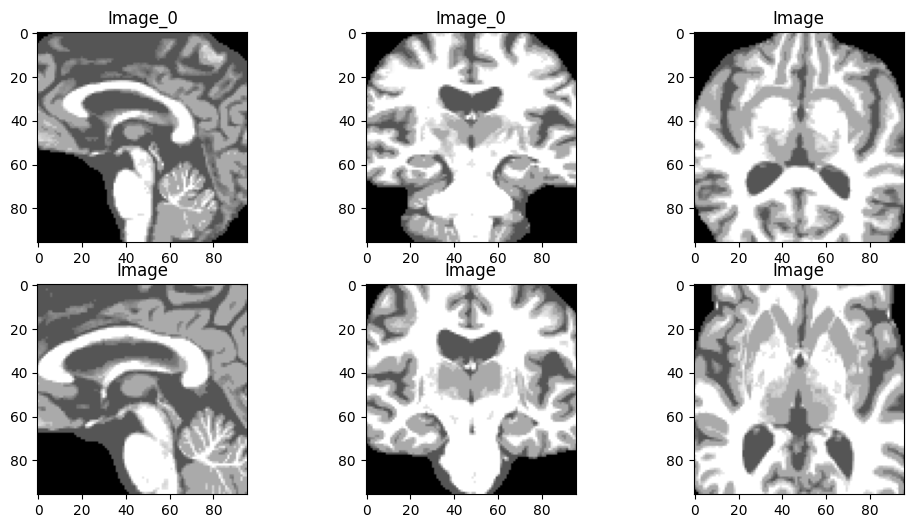

In [187]:
for masked_img, label, group in dataset_val.take(1):
    fig, ax = plt.subplots(2,3, figsize = (12, 6))
    ax[0][0].imshow(masked_img[0][:,:,masked_img[0].shape[2]//2], cmap='gray')
    ax[0][0].set_title('Image_0')
    ax[0][1].imshow(masked_img[0][:,masked_img[0].shape[1]//2, :], cmap='gray')
    ax[0][1].set_title('Image_0')
    ax[0][2].imshow(masked_img[0][masked_img[0].shape[0]//2], cmap='gray')
    ax[0][2].set_title('Image')
    ax[1][0].imshow(masked_img[3][:,:,masked_img[1].shape[2]//2], cmap='gray')
    ax[1][0].set_title('Image')
    ax[1][1].imshow(masked_img[3][:,masked_img[1].shape[1]//2, :], cmap='gray')
    ax[1][1].set_title('Image')
    ax[1][2].imshow(masked_img[3][masked_img[1].shape[0]//2], cmap='gray')
    ax[1][2].set_title('Image')
    print(label)
    print(group)

# Classifier

In [188]:
def _bn_relu(input):
    """
    Helper to build a BN -> relu block (by @raghakot).
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)

def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters, 
            kernel_size=kernel_size,
            strides=strides, 
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer
            )(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv3d(**conv_params):
    """
    Helper to build a  BN -> relu -> conv3d block.
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
                   filters=filters, 
                   kernel_size=kernel_size,
                   strides=strides, 
                   kernel_initializer=kernel_initializer,
                   padding=padding,
                   kernel_regularizer=kernel_regularizer
                   )(activation)
    return f


def _shortcut3d(input, residual):
    """
    3D shortcut to match input and residual and merges them with "sum".
    """
    stride_dim1 = ceil(input.shape[DIM1_AXIS] \
        / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] \
        / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] \
        / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] \
        == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal", 
            padding="valid",
            kernel_regularizer=l2(1e-4)
            )(input)
    return add([shortcut, residual])


def _residual_block3d(block_function, filters, kernel_regularizer, repetitions,
                      is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(
                filters=filters, 
                strides=strides,
                kernel_regularizer=kernel_regularizer,
                is_first_block_of_first_layer=(is_first_layer and i == 0)
                )(input)
        return input

    return f


def basic_block(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
                is_first_block_of_first_layer=False):
    """
    Basic 3 X 3 X 3 convolution blocks. 
    Extended from raghakot's 2D impl.
    """
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(
                filters=filters, 
                kernel_size=(3, 3, 3),
                strides=strides, 
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer
                )(input)
        else:
            conv1 = _bn_relu_conv3d(
                filters=filters,
                kernel_size=(3, 3, 3),
                strides=strides,
                kernel_regularizer=kernel_regularizer
                )(input)
        residual = _bn_relu_conv3d(
            filters=filters, 
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer
            )(conv1)
        return _shortcut3d(input, residual)

    return f


def bottleneck(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
               is_first_block_of_first_layer=False):
    """
    Basic 3 X 3 X 3 convolution blocks. 
    Extended from raghakot's 2D impl.
    """
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(
                filters=filters, 
                kernel_size=(1, 1, 1),
                strides=strides, 
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer
                )(input)
        else:
            conv_1_1 = _bn_relu_conv3d(
                filters=filters, 
                kernel_size=(1, 1, 1),
                strides=strides,
                kernel_regularizer=kernel_regularizer
                )(input)
        conv_3_3 = _bn_relu_conv3d(
            filters=filters, 
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer
            )(conv_1_1)
        residual = _bn_relu_conv3d(
            filters=filters * 4, 
            kernel_size=(1, 1, 1),
            kernel_regularizer=kernel_regularizer
            )(conv_3_3)
        return _shortcut3d(input, residual)
    return f

def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4

def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier

In [189]:
class Resnet3DBuilder(object):
    """
    ResNet3D.
    """

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """
        Instantiate a vanilla ResNet3D keras model.
        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError(
                     "Input shape should be a tuple "
                     "(conv_dim1, conv_dim2, conv_dim3, channels) "
                     "for tensorflow as backend or "
                     "(channels, conv_dim1, conv_dim2, conv_dim3) "
                     "for theano as backend"
                     )

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        # first conv
        conv1 = _conv_bn_relu3D(
            filters=64, 
            kernel_size=(7, 7, 7),
            strides=(2, 2, 2),
            kernel_regularizer=l2(reg_factor)
            )(input)
        pool1 = MaxPooling3D(
            pool_size=(3, 3, 3), 
            strides=(2, 2, 2),
            padding="same")(conv1)

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(
                block_fn, 
                filters=filters,
                kernel_regularizer=l2(reg_factor),
                repetitions=r, 
                is_first_layer=(i == 0)
                )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(
            pool_size=(block.shape[DIM1_AXIS],
                       block.shape[DIM2_AXIS],
                       block.shape[DIM3_AXIS]),
            strides=(1, 1, 1)
            )(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="relu",
                kernel_regularizer=l2(reg_factor)
                )(flatten1)
        else:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="sigmoid",
                kernel_regularizer=l2(reg_factor)
                )(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=1e-4):
        """
        Build resnet 18.
        """
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [2, 2, 2, 2], reg_factor=reg_factor)

In [190]:
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH, CHANNELS)
builder = Resnet3DBuilder()
feature_generator = builder.build_resnet_18(input_shape, 64)
feature_generator.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 96, 96, 96,  0                                            
__________________________________________________________________________________________________
conv3d_80 (Conv3D)              (None, 48, 48, 48, 6 22016       input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 48, 48, 48, 6 256         conv3d_80[0][0]                  
__________________________________________________________________________________________________
activation_68 (Activation)      (None, 48, 48, 48, 6 0           batch_normalization_68[0][0]     
____________________________________________________________________________________________

In [191]:
@tf.custom_gradient
def gradient_reverse(x, lamda=1.0):
    y = tf.identity(x)
    
    def grad(dy):
        return lamda * -dy, None
    
    return y, grad


class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, x, lamda=1.0):
        return gradient_reverse(x, lamda)

In [192]:
class LabelPredictor(Model):
    def __init__(self):
        super(LabelPredictor, self).__init__() 
        # self.label_predictor_layer0 = Dense(512, activation='relu')
        # self.label_predictor_layer1 = Dropout(0.4)
        # self.label_predictor_layer2 = Dense(256, activation='relu')
        # self.label_predictor_layer3 = Dropout(0.3)
        self.label_predictor_layer4 = Dense(2, activation='softmax')
        # self.activation = Activation('softmax')


    def call(self, feature):  
        # lp_x = self.label_predictor_layer0(feature)
        # lp_x = self.label_predictor_layer1(lp_x)
        # lp_x = self.label_predictor_layer2(lp_x)
        # lp_x = self.label_predictor_layer3(lp_x)
        pred = self.label_predictor_layer4(feature)

        return pred

label_predictor = LabelPredictor()

In [193]:
class DomainPredictor(Model):
    def __init__(self):
        super(DomainPredictor, self).__init__()   
        self.domain_predictor_layer0 = GradientReversalLayer()
        # self.domain_predictor_layer1 = Dense(512, activation='relu')
        # self.domain_predictor_layer2 = Dense(256, activation='relu')
        self.domain_predictor_layer3 = Dense(2, activation='softmax')
        # self.activation = Activation('softmax')

    def call(self, feature, lamda=1.0):
        dp_x = self.domain_predictor_layer0(feature, lamda)    #GradientReversalLayer
        # dp_x = self.domain_predictor_layer1(dp_x)
        # dp_x = self.domain_predictor_layer2(dp_x)
        pred = self.domain_predictor_layer3(dp_x)
        return pred

domain_predictor = DomainPredictor()

# Train

In [194]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
d_optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
f_optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
# l_optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)


train_lp_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_lp_accuracy')
train_dc_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_dc_accuracy')
val_lp_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_lp_accuracy')
val_dc_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_dc_accuracy')

train_lp_loss = tf.keras.metrics.Mean(name='train_lp_loss')
train_dc_loss = tf.keras.metrics.Mean(name='train_dc_loss')
val_lp_loss = tf.keras.metrics.Mean(name='val_lp_loss')
val_dc_loss = tf.keras.metrics.Mean(name='val_dc_loss')

In [195]:
@tf.function
def train_step(images, labels, domains, domain = True):
   # labels = tf.cast(labels, tf.float32)
    #domains = tf.cast(domains, tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        logit = feature_generator(images)
        # d_predictions = domain_predictor(logit)
        l_predictions = label_predictor(logit)
        #print(labels)
        lp_loss = loss_object(labels, l_predictions)  
        # dc_loss = loss_object(domains, d_predictions) 
        
    lp_grad = tape.gradient(lp_loss, label_predictor.trainable_variables)
    fe_grad = tape.gradient(lp_loss, feature_generator.trainable_variables)
    
    if domain:
        with tf.GradientTape(persistent=True) as tape:
            logit = feature_generator(images)
            d_predictions = domain_predictor(logit)
            #print(labels)
            dc_loss = loss_object(domains, d_predictions) 

        dc_grad = tape.gradient(dc_loss, domain_predictor.trainable_variables)
        fe_grad += tape.gradient(dc_loss, feature_generator.trainable_variables)

        d_optimizer.apply_gradients(zip(dc_grad, domain_predictor.trainable_variables))
        
    f_optimizer.apply_gradients(zip(fe_grad, feature_generator.trainable_variables))
    
    train_lp_loss(lp_loss)
    train_lp_accuracy(labels, l_predictions)
    
    if domain:
        train_dc_loss(dc_loss)
        train_dc_accuracy(domains, d_predictions)
    

In [196]:
@tf.function
def val_step(images, labels, domains, domain=True):
    #labels = tf.cast(labels, tf.float32)
    #domains = tf.cast(domains, tf.float32)
    
    if domain:
        features = feature_generator(images, training=False)
        l_predictions = label_predictor(features, training=False)
        d_predictions = domain_predictor(features, training=False)
        lp_loss = loss_object(labels, l_predictions)  
        dc_loss = loss_object(domains, d_predictions)  

        val_lp_loss(lp_loss)
        val_lp_accuracy(labels, l_predictions)
        val_dc_loss(dc_loss)
        val_dc_accuracy(domains, d_predictions)
        
    else:
        features = feature_generator(images, training=False)
        l_predictions = label_predictor(features, training=False)
        val_lp_loss(lp_loss)
        val_lp_accuracy(labels, l_predictions)
    
        

In [197]:
def val(domain=True):
    for batch in tqdm(dataset_val):
        val_step(*batch)
        
def test(domain=True):
    for batch in tqdm(dataset_test):
        val_step(*batch)

def reset_metrics(target):

    if target == 'train':
        train_lp_loss.reset_states()
        train_lp_accuracy.reset_states()
        train_dc_loss.reset_states()
        train_dc_accuracy.reset_states()

    if target == 'val':
        val_lp_loss.reset_states()
        val_lp_accuracy.reset_states()
        val_dc_loss.reset_states()
        val_dc_accuracy.reset_states()


In [198]:
epochs = 30
prev = 0
for epoch in range(epochs):
    for batch in tqdm(dataset_train):
        train_step(*batch, domain=True)

    print("Training: Epoch {} :\t Accuracy : {:.3%}, loss : {}, Group Accuracy : {:.3%}, GroupLoss: {}"
          .format(epoch, train_lp_accuracy.result(), train_lp_loss.result(), train_dc_accuracy.result(), train_dc_loss.result()))
    
    reset_metrics('train')
    
    val(domain=True)
    val_acc = val_lp_accuracy.result()
    print("Val: Accuracy : {:.3%}, loss : {}, Group Accuracy : {:.3%}, GroupLoss: {}"
          .format(val_lp_accuracy.result(), val_lp_loss.result(), val_dc_accuracy.result(), val_dc_loss.result()))
    
    if val_acc > prev:
        prev = val_acc
        print('save acc: {}'.format(val_acc))
        feature_generator.save_weights("./model/adversarial/feature_adversarial_gender_fold_" + fold + "_2")
        label_predictor.save_weights("./model/adversarial/label_adversarial_gender_fold_" + fold + "_2")
        domain_predictor.save_weights("./model/adversarial/domain_adversarial_gender_fold_" + fold + "_2")
        
    reset_metrics('val')

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:45<00:00,  2.29it/s]


Training: Epoch 0 :	 Accuracy : 57.788%, loss : 163.2220916748047, Group Accuracy : 49.231%, GroupLoss: 23.988941192626953


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  4.82it/s]


Val: Accuracy : 65.000%, loss : 0.7155551314353943, Group Accuracy : 48.750%, GroupLoss: 1.1382440328598022
save acc: 0.6499999761581421


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.40it/s]


Training: Epoch 1 :	 Accuracy : 64.231%, loss : 0.6299734115600586, Group Accuracy : 48.942%, GroupLoss: 0.9746501445770264


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.38it/s]


Val: Accuracy : 65.417%, loss : 0.6513186097145081, Group Accuracy : 48.333%, GroupLoss: 0.824472963809967
save acc: 0.6541666388511658


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.41it/s]


Training: Epoch 2 :	 Accuracy : 68.077%, loss : 0.5930981040000916, Group Accuracy : 48.846%, GroupLoss: 0.8533017039299011


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.47it/s]


Val: Accuracy : 66.250%, loss : 0.6301299929618835, Group Accuracy : 47.917%, GroupLoss: 0.8239068984985352
save acc: 0.6625000238418579


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.41it/s]


Training: Epoch 3 :	 Accuracy : 70.673%, loss : 0.5729454159736633, Group Accuracy : 45.673%, GroupLoss: 0.8102045655250549


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.65it/s]


Val: Accuracy : 67.917%, loss : 0.6156932711601257, Group Accuracy : 44.167%, GroupLoss: 0.7961681485176086
save acc: 0.6791666746139526


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.41it/s]


Training: Epoch 4 :	 Accuracy : 72.596%, loss : 0.5386135578155518, Group Accuracy : 41.827%, GroupLoss: 0.7800036072731018


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.50it/s]


Val: Accuracy : 69.583%, loss : 0.5897367000579834, Group Accuracy : 40.833%, GroupLoss: 0.7775567173957825
save acc: 0.6958333253860474


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.37it/s]


Training: Epoch 5 :	 Accuracy : 75.577%, loss : 0.516057550907135, Group Accuracy : 41.538%, GroupLoss: 0.7785842418670654


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.36it/s]


Val: Accuracy : 53.333%, loss : 0.6929647922515869, Group Accuracy : 40.000%, GroupLoss: 0.7629086971282959


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:45<00:00,  2.28it/s]


Training: Epoch 6 :	 Accuracy : 75.288%, loss : 0.520139217376709, Group Accuracy : 40.962%, GroupLoss: 0.7740339040756226


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.69it/s]


Val: Accuracy : 72.917%, loss : 0.5647097229957581, Group Accuracy : 40.833%, GroupLoss: 0.7612389922142029
save acc: 0.7291666865348816


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:44<00:00,  2.36it/s]


Training: Epoch 7 :	 Accuracy : 76.058%, loss : 0.49331262707710266, Group Accuracy : 41.827%, GroupLoss: 0.7767872214317322


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.62it/s]


Val: Accuracy : 53.750%, loss : 0.6968927383422852, Group Accuracy : 47.083%, GroupLoss: 0.759850800037384


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 8 :	 Accuracy : 78.173%, loss : 0.4746161103248596, Group Accuracy : 40.385%, GroupLoss: 0.7737087607383728


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.36it/s]


Val: Accuracy : 73.750%, loss : 0.5573598742485046, Group Accuracy : 42.083%, GroupLoss: 0.7613663077354431
save acc: 0.737500011920929


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.38it/s]


Training: Epoch 9 :	 Accuracy : 77.404%, loss : 0.4737545847892761, Group Accuracy : 40.096%, GroupLoss: 0.7726949453353882


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.52it/s]


Val: Accuracy : 71.250%, loss : 0.6386648416519165, Group Accuracy : 39.167%, GroupLoss: 0.7637507319450378


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 10 :	 Accuracy : 80.385%, loss : 0.44742071628570557, Group Accuracy : 41.538%, GroupLoss: 0.7766202092170715


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.62it/s]


Val: Accuracy : 75.000%, loss : 0.5467480421066284, Group Accuracy : 45.000%, GroupLoss: 0.7589178085327148
save acc: 0.75


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 11 :	 Accuracy : 78.654%, loss : 0.44328972697257996, Group Accuracy : 41.058%, GroupLoss: 0.7740556001663208


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.50it/s]


Val: Accuracy : 73.750%, loss : 0.5633792281150818, Group Accuracy : 38.750%, GroupLoss: 0.7723322510719299


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 12 :	 Accuracy : 81.346%, loss : 0.4208593964576721, Group Accuracy : 41.538%, GroupLoss: 0.7762784957885742


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.64it/s]


Val: Accuracy : 58.333%, loss : 0.6801941394805908, Group Accuracy : 47.500%, GroupLoss: 0.7542402148246765


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 13 :	 Accuracy : 81.635%, loss : 0.41267091035842896, Group Accuracy : 41.442%, GroupLoss: 0.7790317535400391


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.54it/s]


Val: Accuracy : 65.833%, loss : 0.5955130457878113, Group Accuracy : 46.667%, GroupLoss: 0.7709379196166992


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 14 :	 Accuracy : 81.250%, loss : 0.41144078969955444, Group Accuracy : 42.212%, GroupLoss: 0.7784997224807739


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.66it/s]


Val: Accuracy : 75.833%, loss : 0.5308986306190491, Group Accuracy : 47.500%, GroupLoss: 0.763845682144165
save acc: 0.7583333253860474


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 15 :	 Accuracy : 85.000%, loss : 0.380959153175354, Group Accuracy : 42.308%, GroupLoss: 0.7831705808639526


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.55it/s]


Val: Accuracy : 59.167%, loss : 0.6530479788780212, Group Accuracy : 46.250%, GroupLoss: 0.7836997509002686


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 16 :	 Accuracy : 86.346%, loss : 0.35071104764938354, Group Accuracy : 41.250%, GroupLoss: 0.7845531702041626


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.79it/s]


Val: Accuracy : 75.833%, loss : 0.5219480395317078, Group Accuracy : 46.667%, GroupLoss: 0.7750241160392761


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.40it/s]


Training: Epoch 17 :	 Accuracy : 86.538%, loss : 0.3537614643573761, Group Accuracy : 41.442%, GroupLoss: 0.7870126962661743


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.46it/s]


Val: Accuracy : 76.667%, loss : 0.5196537375450134, Group Accuracy : 46.667%, GroupLoss: 0.7719835638999939
save acc: 0.7666666507720947


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 18 :	 Accuracy : 85.673%, loss : 0.34691765904426575, Group Accuracy : 42.885%, GroupLoss: 0.7857784032821655


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.49it/s]


Val: Accuracy : 76.667%, loss : 0.5351170301437378, Group Accuracy : 46.250%, GroupLoss: 0.769826352596283


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 19 :	 Accuracy : 86.250%, loss : 0.3411283791065216, Group Accuracy : 42.596%, GroupLoss: 0.7801342010498047


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.47it/s]


Val: Accuracy : 72.917%, loss : 0.6731734275817871, Group Accuracy : 43.333%, GroupLoss: 0.7688282132148743


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 20 :	 Accuracy : 88.173%, loss : 0.3185100853443146, Group Accuracy : 42.404%, GroupLoss: 0.7817935347557068


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.43it/s]


Val: Accuracy : 79.167%, loss : 0.5102465748786926, Group Accuracy : 45.417%, GroupLoss: 0.7723821997642517
save acc: 0.7916666865348816


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 21 :	 Accuracy : 90.577%, loss : 0.29221299290657043, Group Accuracy : 41.923%, GroupLoss: 0.7866337299346924


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.58it/s]


Val: Accuracy : 75.000%, loss : 0.6058286428451538, Group Accuracy : 42.500%, GroupLoss: 0.7725722789764404


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 22 :	 Accuracy : 89.904%, loss : 0.28006887435913086, Group Accuracy : 42.212%, GroupLoss: 0.7860667705535889


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.63it/s]


Val: Accuracy : 75.000%, loss : 0.6018007397651672, Group Accuracy : 38.333%, GroupLoss: 0.7804774641990662


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 23 :	 Accuracy : 91.154%, loss : 0.2515009343624115, Group Accuracy : 42.981%, GroupLoss: 0.7857227325439453


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.59it/s]


Val: Accuracy : 80.417%, loss : 0.5134600400924683, Group Accuracy : 47.917%, GroupLoss: 0.7745857834815979
save acc: 0.8041666746139526


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 24 :	 Accuracy : 90.962%, loss : 0.24981950223445892, Group Accuracy : 42.692%, GroupLoss: 0.7875179648399353


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.49it/s]


Val: Accuracy : 79.583%, loss : 0.5129685997962952, Group Accuracy : 43.333%, GroupLoss: 0.7790527939796448


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 25 :	 Accuracy : 91.731%, loss : 0.25264793634414673, Group Accuracy : 43.365%, GroupLoss: 0.7874047160148621


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.57it/s]


Val: Accuracy : 80.833%, loss : 0.4997589588165283, Group Accuracy : 46.250%, GroupLoss: 0.7766509056091309
save acc: 0.8083333373069763


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 26 :	 Accuracy : 93.173%, loss : 0.21350589394569397, Group Accuracy : 42.404%, GroupLoss: 0.7890380024909973


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.86it/s]


Val: Accuracy : 77.500%, loss : 0.5529460906982422, Group Accuracy : 39.583%, GroupLoss: 0.7735744118690491


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.39it/s]


Training: Epoch 27 :	 Accuracy : 92.212%, loss : 0.2197594940662384, Group Accuracy : 41.731%, GroupLoss: 0.7924518585205078


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.60it/s]


Val: Accuracy : 79.583%, loss : 0.5372605919837952, Group Accuracy : 45.000%, GroupLoss: 0.7671211361885071


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.38it/s]


Training: Epoch 28 :	 Accuracy : 94.712%, loss : 0.1825893223285675, Group Accuracy : 43.654%, GroupLoss: 0.7889651656150818


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.56it/s]


Val: Accuracy : 75.417%, loss : 0.6606377959251404, Group Accuracy : 41.250%, GroupLoss: 0.764983594417572


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:43<00:00,  2.38it/s]


Training: Epoch 29 :	 Accuracy : 95.096%, loss : 0.1781938225030899, Group Accuracy : 43.077%, GroupLoss: 0.7869763970375061


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.66it/s]


Val: Accuracy : 81.250%, loss : 0.5268298387527466, Group Accuracy : 43.750%, GroupLoss: 0.7683120369911194
save acc: 0.8125


# Test

In [224]:
feature_generator.load_weights("./model/adversarial/feature_adversarial_age_fold_" + fold + "_1")
label_predictor.load_weights("./model/adversarial/label_adversarial_age_fold_" + fold + "_1")
domain_predictor.load_weights("./model/adversarial/domain_adversarial_age_fold_" + fold + "_1")

In [225]:
feature_generator.save_weights("./model/adversarial/feature_adversarial_gender_fold_" + fold + "_1")
label_predictor.save_weights("./model/adversarial/label_adversarial_gender_fold_" + fold + "_1")
domain_predictor.save_weights("./model/adversarial/domain_adversarial_gender_fold_" + fold + "_1")

In [293]:
reset_metrics('val')
test(domain=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:20<00:00,  1.84it/s]


In [294]:
val_lp_accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.8201754>

# Evaluate

In [106]:
y_pred = []
y_true = []
for img, label, group in tqdm(dataset_test):
    feat = feature_generator.predict(img)
    # pred = model.predict(masked_img)
    # print(pred.shape)
    # print(pred)
    for each in label_predictor.predict(feat):
        # print(prob.shape)
        # each = [1-prob[0], prob[0]]
        # print(each)
        # for pred in each:
        y_pred.append(each)
    for each in label.numpy():
        # print(each)
        y_true.append(each[0])
    # break

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:13<00:00,  2.64it/s]


In [107]:
len(y_pred), len(y_true)

(210, 210)

In [108]:
y_pred[0]

array([0.02887605, 0.9711239 ], dtype=float32)

In [109]:
y_pred_one_label = []
for each in y_pred:
    y_pred_one_label.append(np.argmax(each))

## Confusion Matrix

In [110]:
cm = confusion_matrix(y_true, y_pred_one_label)
cm

array([[ 57,  27],
       [ 24, 102]], dtype=int64)

<AxesSubplot:>

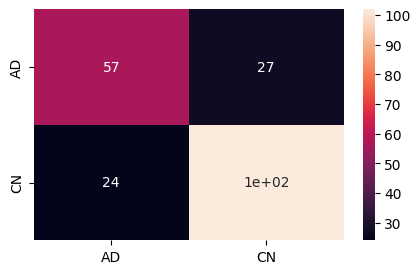

In [111]:
# df_cm = pd.DataFrame(cm, index = ['AD', 'CN', 'MCI'], columns = ['AD', 'CN', 'MCI'])
df_cm = pd.DataFrame(cm, index = ['AD','CN'], columns = ['AD','CN'])
plt.figure(figsize=(5,3))
sn.heatmap(df_cm, annot=True)

In [112]:
print(classification_report(y_true, y_pred_one_label, digits=3))

              precision    recall  f1-score   support

           0      0.704     0.679     0.691        84
           1      0.791     0.810     0.800       126

    accuracy                          0.757       210
   macro avg      0.747     0.744     0.745       210
weighted avg      0.756     0.757     0.756       210



# Age and Gender

In [239]:
gender_df = data_val
# male_df = gender_dvalnder_df.Sex == 'M']
# male_df = gender_df[(gender_df.Age > 50) & (gender_df.Age <= 70)]
male_df = gender_df[(gender_df.Age == 2)]
# male_df = gender_df
print(male_df.shape)
male_df.head()

(60, 6)


,Links,Group,Sex,Age,ETH,RACE
173,D:\Lab\ADNI\136_S_0426\MPR__GradWarp__B1_Corre...,AD,M,2,Not Hisp/Latino,White
174,D:\Lab\ADNI\002_S_0938\MPR__GradWarp__B1_Corre...,AD,F,2,Not Hisp/Latino,White
175,D:\Lab\ADNI\041_S_1435\MPR__GradWarp__B1_Corre...,AD,M,2,Not Hisp/Latino,White
176,D:\Lab\ADNI\136_S_0426\MPR__GradWarp__B1_Corre...,AD,M,2,Not Hisp/Latino,White
177,D:\Lab\ADNI\002_S_0938\MPR__GradWarp__B1_Corre...,AD,F,2,Not Hisp/Latino,White


In [240]:
gender_path_val = male_df['Links'].to_numpy()
gender_label_val = male_df['Group'].to_numpy()
gender_path_val = male_df['Links'].to_numpy()
gender_label_val = [label_to_index[l] for l in gender_label_val]
gender_label_val = np.array(gender_label_val).reshape((-1, 1))
group_val = male_df['Age'].to_numpy()
group_val = np.array(group_val).reshape((-1, 1))

gender_val = tf.data.Dataset.from_tensor_slices((np.array(gender_path_val), gender_label_val, group_val))
gender_val = gender_val.map(wrapper_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
gender_val = gender_val.batch(1, drop_remainder=True)

In [241]:
def get_id(l):
    return l.split('\\')[3]

In [242]:
unique, count = np.unique(gender_label_val, return_counts=True)
dict(zip(['AD','CN','MCI'], count))

{'AD': 19, 'CN': 41}

In [243]:
y_pred_gender = []
y_true_gender = []
for img, label, group in tqdm(gender_val):
    feature = feature_generator.predict(img)
    for each in label_predictor.predict(feature):
        # for pred in each:
        y_pred_gender.append(each)
    for each in label.numpy():
        y_true_gender.append(each[0])

y_pred_gender_one_label = []
for each in y_pred_gender:
    y_pred_gender_one_label.append(np.argmax(each))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.76it/s]


## Confusion Matrix

In [244]:
cm = confusion_matrix(y_true_gender, y_pred_gender_one_label)
cm

array([[10,  9],
       [ 4, 37]], dtype=int64)

<AxesSubplot:>

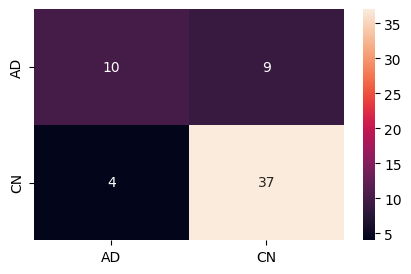

In [245]:
# df_cm = pd.DataFrame(cm, index = ['AD', 'CN', 'MCI'], columns = ['AD', 'CN', 'MCI'])
df_cm = pd.DataFrame(cm, index = ['AD','CN'], columns = ['AD','CN'])
plt.figure(figsize=(5,3))
sn.heatmap(df_cm, annot=True)

In [246]:
print(classification_report(y_true_gender, y_pred_gender_one_label, digits=3))

              precision    recall  f1-score   support

           0      0.714     0.526     0.606        19
           1      0.804     0.902     0.851        41

    accuracy                          0.783        60
   macro avg      0.759     0.714     0.728        60
weighted avg      0.776     0.783     0.773        60

